# Implementation of the Fast Gradient Sign Method (FGSM)

## 1. Loading the model and images to attack
We will use the model `ResNet18`, trained on the `ImageNet` dataset, to conduct our experiments.

In [1]:
import torch
from torch import nn
from torchvision import models, transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import requests
import numpy as np
from copy import deepcopy

/Users/pgberlureau/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
net = models.resnet18(pretrained=True)
net.eval()

transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

/Users/pgberlureau/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pgberlureau/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
n_mean = [0.485, 0.456, 0.406]
n_std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(
   mean=n_mean,
   std=n_std
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

t_std = torch.from_numpy(np.array(n_std, dtype=np.float32)).view(-1, 1, 1)
t_mean = torch.from_numpy(np.array(n_mean, dtype=np.float32)).view(-1, 1, 1)

def plot_img_tensor(img, ax):
    ax.imshow(np.transpose(img.detach().numpy(), [1,2,0]))

def plot_untransform(x_t, ax):
    x_np = (x_t * t_std + t_mean).detach().numpy()
    x_np = np.transpose(x_np, [1, 2, 0])
    ax.imshow(x_np)

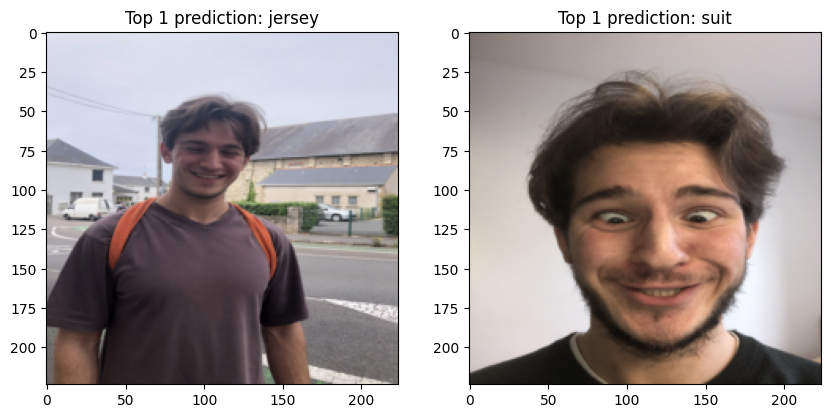

In [4]:
face = Image.open('face.jpg')
grimace = Image.open('grimace.jpg')

face_tensor = preprocess(face)
grimace_tensor = preprocess(grimace)

face_pred = net(face_tensor.unsqueeze(0))
grimace_pred = net(grimace_tensor.unsqueeze(0))

face_img = (face_tensor * t_std + t_mean).squeeze(0)
grimace_img = (grimace_tensor * t_std + t_mean).squeeze(0)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("Top 1 prediction: "+str(classes[face_pred.argmax().item()][1]))
ax[1].set_title("Top 1 prediction: "+str(classes[grimace_pred.argmax().item()][1]))
plot_img_tensor(face_img, ax[0])
plot_img_tensor(grimace_img, ax[1])

Although a jersey is a prominent feature in the first image, the second image does not contain a suit. Given that merely altering facial expressions appears sufficient to constitute an adversarial attack on ResNet18, subsequent experiments will be limited to the first image.

## 2. Implementation of FGSM for confidence reduction
We implement the simplest case of FGSM, using the following equation:
$$X_* = \text{Clamp}(X + \varepsilon\text{ sign}\left(\nabla_x J(X, y_{\text{true}})\right))$$

In [12]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    grad_sign = torch.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    adjusted_image = image + epsilon * grad_sign

    # Adding clipping to maintain [0,1] range
    perturbed_image = adjusted_image.clamp(0, 1)

    # Return the perturbed image
    return perturbed_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.001000002..0.001000002].


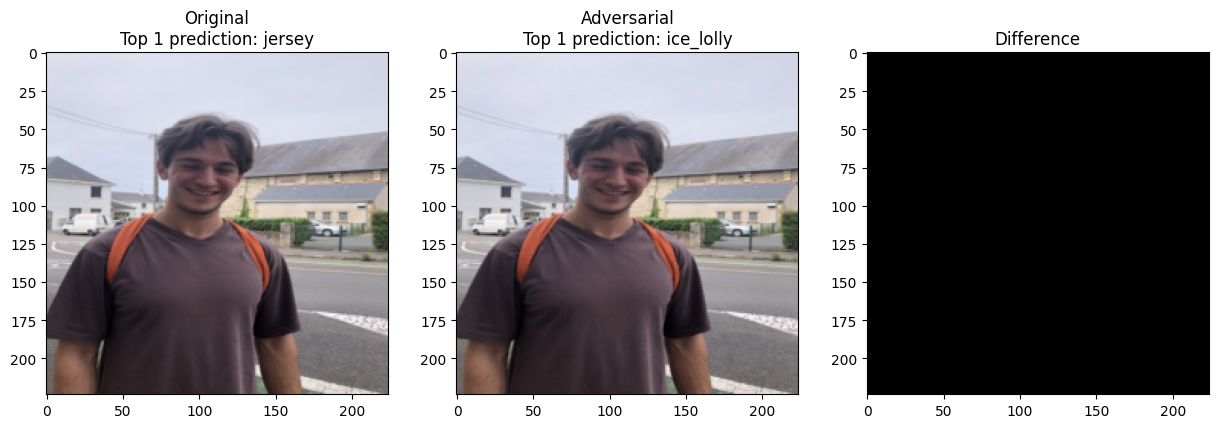

In [ ]:
idx = face_pred.argmax().item()
criterion = nn.CrossEntropyLoss()
face_img.requires_grad = True
logit = net(normalize(face_img).unsqueeze(0))
target = torch.tensor([idx])

loss = criterion(logit, target)
loss.backward()

epsilon = 0.001
x_att = fgsm_attack(face_img,epsilon,face_img.grad)
x_att_pred = net(normalize(x_att.unsqueeze(0)))

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].set_title("Original\nTop 1 prediction: "+str(classes[face_pred.argmax().item()][1]))
ax[1].set_title("Adversarial\nTop 1 prediction: "+str(classes[x_att_pred.argmax().item()][1]))
ax[2].set_title("Difference")
plot_img_tensor(face_img, ax[0])
plot_img_tensor(x_att, ax[1])
plot_img_tensor(x_att - face_img, ax[2])
plt.show()

Even with a minimal FGSM perturbation that is imperceptible to the human eye, the model misclassifies the image as depicting an ice lolly.

In the remainder of the experiment, we attempt to fool the model into misclassifying the image as depicting a tabby, a specific breed of cat.

## 3. Variation of FGSM for source/target misclassification
We modify FGSM to specifically choose the target class, i.e. the class that we want our crafted image to be classified as:
$$X_* = \text{Clamp}(X - \varepsilon\text{ sign}\left(\nabla_x J(X, y_{\text{target}})\right))$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02000001..0.02000001].


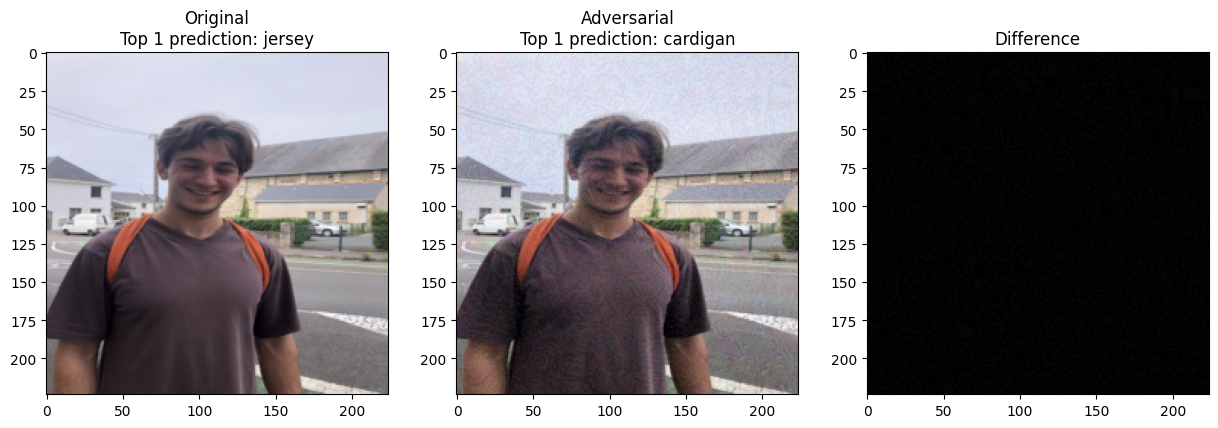

In [7]:
idx = 281
img = deepcopy(face_img)
criterion = nn.CrossEntropyLoss()
img.requires_grad = True
logit = net(normalize(img).unsqueeze(0))
target = torch.tensor([idx])
loss = criterion(logit, target)
loss.backward()
epsilon = 0.02

x_att = fgsm_attack(img,epsilon,-img.grad)

x_att_pred = net(normalize(x_att.unsqueeze(0)))
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].set_title("Original\nTop 1 prediction: "+str(classes[face_pred.argmax().item()][1]))
ax[1].set_title("Adversarial\nTop 1 prediction: "+str(classes[x_att_pred.argmax().item()][1]))
ax[2].set_title("Difference")
plot_img_tensor(img, ax[0])
plot_img_tensor(x_att, ax[1])
plot_img_tensor(x_att - img, ax[2])
plt.show()

To keep the attack imperceptible to the human eye, the best misclassification achievable is the model predicting the image as a cardigan. However, this result is not quite satisfying, as the prediction is not sufficiently absurd -- a jersey is not semantically that far from a cardigan.

## 4. Iterating FGSM
Finally, we iterate FGSM over multiple steps of gradient evaluation, and compare the results to the single-step setup:
$$\begin{cases}
        X_*^0 \quad= X\\
        X^{n+1}_* = \text{Clamp}\left(X^n_*-\varepsilon\text{ sign}\left(\nabla_x J(X, y_{\text{target}})\right)\right)
\end{cases}$$

In [8]:
idx = 281
img = deepcopy(face_img)
optimizer = optim.SGD([img], lr=0.01)
target = torch.tensor([idx])

for i in range(200):
    output = net(normalize(img).unsqueeze(0))

    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
            img.clamp_(0,1)
    
    print("Top 1 prediction: "+str(classes[torch.argmax(output).item()][1]))
    print(i,'-----------------')

    if torch.argmax(output) == idx:
        break

Top 1 prediction: jersey
0 -----------------
Top 1 prediction: jersey
1 -----------------
Top 1 prediction: jersey
2 -----------------
Top 1 prediction: jersey
3 -----------------
Top 1 prediction: jersey
4 -----------------
Top 1 prediction: jersey
5 -----------------
Top 1 prediction: jersey
6 -----------------
Top 1 prediction: neck_brace
7 -----------------
Top 1 prediction: neck_brace
8 -----------------
Top 1 prediction: neck_brace
9 -----------------
Top 1 prediction: tabby
10 -----------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02751559..0.01834464].


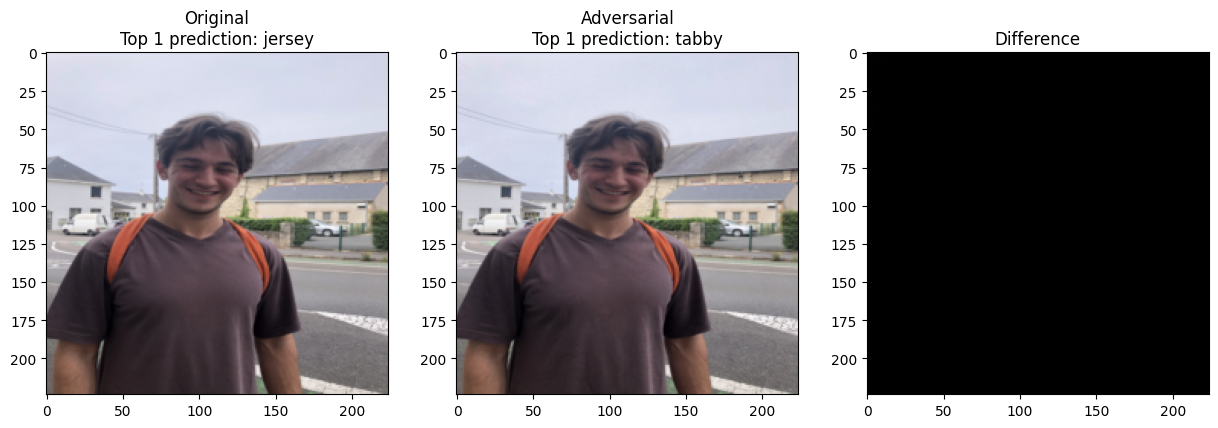

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].set_title("Original\nTop 1 prediction: "+str(classes[face_pred.argmax().item()][1]))
ax[1].set_title("Adversarial\nTop 1 prediction: "+str(classes[output.argmax().item()][1]))
ax[2].set_title("Difference")
plot_img_tensor(face_img, ax[0])
plot_img_tensor(img, ax[1])
plot_img_tensor(img - face_img, ax[2])
plt.show()

We are able to fool the model into classifying the image as featuring a tabby in only $10$ gradient steps. Additionally, the difference between the original and the adversarial images is imperceptible to the human eye.